In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/Xe137Study


In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [3]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [6]:
categories_list = ['0.01x','00.1x','00.3x','01.0x','03.0x','10.0x','100.0x']
outputdir = '/p/lustre1/lenardo1/sensitivity_output/June23_2020_Xe137_test/'
outputdir = '/p/lustre2/lenardo1/sensitivity_output/Jan19_Xe137_Study_merged-v10b_D024/'
outputdir = '/p/lustre2/lenardo1/sensitivity_output/Mar1_Xe137_Study_merged-v11_D024/'

all_files = os.listdir(outputdir)
h5_files = [filename for filename in all_files if 'reanalyzed' in filename and filename.endswith('.h5')]

dfdict = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list = [pd.read_hdf(outputdir+filename) for filename in h5_files if '_'+category+'_' in filename]
    dfdict[category] = pd.concat(df_list,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict[category])))


Loading data for 0.01x
---> Loaded 5000 toy datasets
Loading data for 00.1x
---> Loaded 5000 toy datasets
Loading data for 00.3x
---> Loaded 5000 toy datasets
Loading data for 01.0x
---> Loaded 5000 toy datasets
Loading data for 03.0x
---> Loaded 5000 toy datasets
Loading data for 10.0x
---> Loaded 5000 toy datasets
Loading data for 100.0x
---> Loaded 5000 toy datasets


In [7]:
# baselinedir = '/p/lustre1/lenardo1/sensitivity_output/June23_2020_Xe137_test/'
# all_files = os.listdir(baselinedir)
# h5_files = [filename for filename in all_files if (filename.endswith('.h5') and '_1x_' in filename)]
# df_list = [pd.read_hdf(baselinedir+filename) for filename in h5_files]
# baselinedf = pd.concat(df_list,ignore_index=True)

# dfdict['Baseline'] = baselinedf




In [8]:
# Get the median values of lambda

maskdict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or not row['best_fit_covar'] \
            or row['90CL_crossing'] < 0.01\
            or row['best_fit_nll']>0.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict[key])/len(maskdict[key])))
            
    
        

Running 0.01x
---> Convergence fraction: 0.99
Running 00.1x
---> Convergence fraction: 0.991
Running 00.3x
---> Convergence fraction: 0.99
Running 01.0x
---> Convergence fraction: 0.973
Running 03.0x
---> Convergence fraction: 0.958
Running 10.0x
---> Convergence fraction: 0.985
Running 100.0x
---> Convergence fraction: 0.958


Running 0.01x
---> Median 90%CL on signal counts: 6.180618061806181
Running 00.1x
---> Median 90%CL on signal counts: 6.200620062006201
Running 00.3x
---> Median 90%CL on signal counts: 6.310631063106311
Running 01.0x
---> Median 90%CL on signal counts: 6.420642064206421
Running 03.0x
---> Median 90%CL on signal counts: 7.040704070407041
Running 10.0x
---> Median 90%CL on signal counts: 8.205820582058205
Running 100.0x
---> Median 90%CL on signal counts: 14.831483148314833


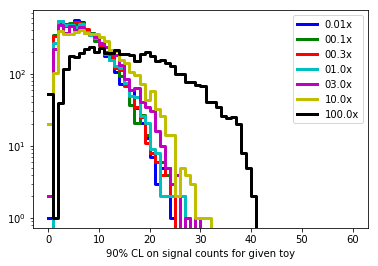

In [9]:
histdict = dict()
mediandict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    histdict[key] = hl.hist(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]], bins=np.linspace(0.,60.,61))
    
    mediandict[key] = np.median(dfdict[key]['90CL_crossing_EXACT'].loc[maskdict[key]])
    
    print('---> Median 90%CL on signal counts: {}'.format(mediandict[key]))
    
    hl.plot1d(histdict[key],label=key,linewidth=3)

    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')
            
 

In [10]:
def ComputeHalflifeFromNumCounts( counts ):
    
    # Returns the half life which would give (on average) the input number of signal counts
    
    N_A = 6.02e23 # atoms/mol
    FidMass = 3281 # kg
    AtomicMass = 135.8 # g/mol
    EnrichmentFraction = 0.9
    SigEfficiency = 0.96
    Livetime = 10 # years
    
    return FidMass*1.e3 / AtomicMass * N_A * EnrichmentFraction * Livetime * \
            SigEfficiency * np.log(2) / counts




0.01	1.409e+28
 0.1	1.405e+28
 0.3	1.38e+28
 1.0	1.357e+28
 3.0	1.237e+28
10.0	1.062e+28
100.0	5.873e+27


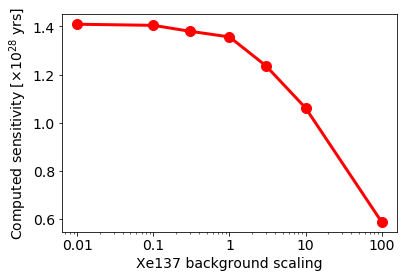

In [13]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (6,4)

x_points = []
y_points = []

for key,value in mediandict.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points.append(factor)
    y_points.append(ComputeHalflifeFromNumCounts(value))
    
x_points = np.array(x_points)
y_points = np.array(y_points)
    
sorted_idxs = np.argsort(x_points)

x_points = x_points[sorted_idxs]
y_points = y_points[sorted_idxs]
    
plt.plot(x_points,y_points/1.e28,'-or',markersize=10,\
         label='Electroformed Cu',linewidth=3)
plt.xscale('log')
#plt.ylim(0.2,1.2)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Xe137 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.,],['0.01','0.1','1','10','100'])

plt.savefig('xe137_sensitivity_vs_scale_factor.png',dpi=200,bbox_inches='tight')

for i in range(len(x_points)):

    print('{:4.4}\t{:4.4}'.format(x_points[i],y_points[i]))
    
output_df = pd.DataFrame({'Xe137 scaling': x_points, 'Sensitivity (yrs)': y_points})
output_df.to_csv('../PaperPlots/Data/d024_sensitivity_vs_xe137.csv',index=False)
    

0.01	1.039
 0.1	1.035
 0.3	1.017
 1.0	 1.0
 3.0	0.9119
10.0	0.7824
100.0	0.4329


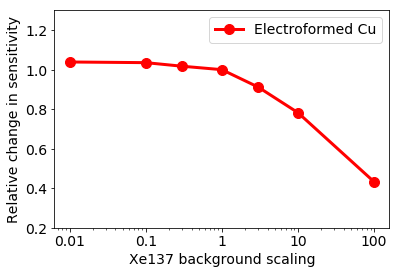

In [12]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (6,4)

x_points = []
y_points = []

for key,value in mediandict.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points.append(factor)
    y_points.append((1./value)/(1./mediandict['01.0x']))
    
x_points = np.array(x_points)
y_points = np.array(y_points)
    
sorted_idxs = np.argsort(x_points)

x_points = x_points[sorted_idxs]
y_points = y_points[sorted_idxs]
    
plt.plot(x_points,y_points,'-or',markersize=10,\
         linewidth=3,label='Electroformed Cu')
plt.xscale('log')
plt.ylim(0.2,1.3)
plt.ylabel('Relative change in sensitivity')
plt.xlabel('Xe137 background scaling')
plt.xticks([0.01,0.1,1.,10.,100.,],['0.01','0.1','1','10','100'])
plt.legend()
#plt.grid()

plt.savefig('xe137_sensitivity_vs_scale_factor.png',dpi=200,bbox_inches='tight')

for i in range(len(x_points)):

    print('{:4.4}\t{:4.4}'.format(x_points[i],y_points[i]))

# Scaling the Vessel_U238 backgrounds instead

In [32]:
categories_list = ['0.01x','00.1x','00.3x','01.0x','10.0x','100.0x']
outputdir = '/p/lustre2/lenardo1/sensitivity_output/Jan29_Xe137_OtherBkgs_Study_merged-v10b_D024/'

all_files = os.listdir(outputdir)
h5_files_vessel = [filename for filename in all_files if filename.endswith('.h5') and 'vesselu238' in filename]

dfdict_vessel = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list_vessel = [pd.read_hdf(outputdir+filename) for filename in h5_files_vessel if '_'+category+'_' in filename]
    dfdict_vessel[category] = pd.concat(df_list_vessel,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict_vessel[category])))
    
    

Loading data for 0.01x
---> Loaded 5000 toy datasets
Loading data for 00.1x
---> Loaded 5000 toy datasets
Loading data for 00.3x
---> Loaded 5000 toy datasets
Loading data for 01.0x
---> Loaded 5000 toy datasets
Loading data for 10.0x
---> Loaded 5000 toy datasets
Loading data for 100.0x
---> Loaded 5000 toy datasets


In [52]:
# Get the median values of lambda

maskdict_vessel = dict()

for key, df in dfdict_vessel.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-2 \
            or not row['best_fit_covar'] \
            or row['90CL_crossing'] < 0.01 \
            or row['best_fit_nll'] > 0.:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict_vessel[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict_vessel[key])/len(maskdict_vessel[key])))
            
    


Running 0.01x
---> Convergence fraction: 0.989
Running 00.1x
---> Convergence fraction: 0.989
Running 00.3x
---> Convergence fraction: 0.982
Running 01.0x
---> Convergence fraction: 0.983
Running 10.0x
---> Convergence fraction: 0.987
Running 100.0x
---> Convergence fraction: 0.833


Running 0.01x
---> Median 90%CL on signal counts: 6.760676067606761
Running 00.1x
---> Median 90%CL on signal counts: 6.670667066706671
Running 00.3x
---> Median 90%CL on signal counts: 6.660666066606661
Running 01.0x
---> Median 90%CL on signal counts: 6.770677067706771
Running 10.0x
---> Median 90%CL on signal counts: 7.490749074907491
Running 100.0x
---> Median 90%CL on signal counts: 9.140914091409142


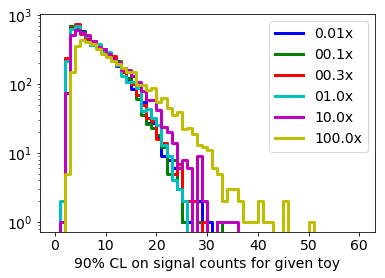

In [53]:
histdict_vessel = dict()
mediandict_vessel = dict()

for key, df in dfdict_vessel.items():
    print('Running {}'.format(key))
    
    histdict_vessel[key] = hl.hist(dfdict_vessel[key]['90CL_crossing'].loc[maskdict_vessel[key]], bins=np.linspace(0.,60.,61))
    
    mediandict_vessel[key] = np.median(dfdict_vessel[key]['90CL_crossing'].loc[maskdict_vessel[key]])
    
    print('---> Median 90%CL on signal counts: {}'.format(mediandict_vessel[key]))
    
    hl.plot1d(histdict_vessel[key],label=key,linewidth=3)

    
plt.legend()
plt.xlabel('90% CL on signal counts for given toy')
plt.yscale('log')




0.01	1.288e+28
 0.1	1.306e+28
 0.3	1.308e+28
 1.0	1.287e+28
10.0	1.163e+28
100.0	9.529e+27


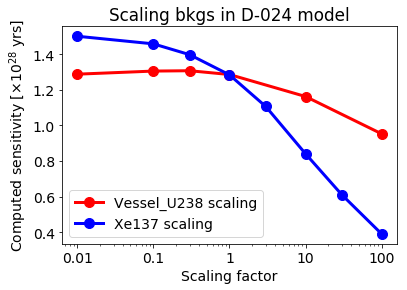

In [54]:
#plt.plot(1.,1.,'ob',markersize=10)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (6,4)

x_points_vessel = []
y_points_vessel = []

for key,value in mediandict_vessel.items():
    
    if key == 'Baseline': continue
    
    factor = float(key.replace('x',''))
   
    #plt.plot(factor,(1/value)/(1/mediandict['Baseline']),'ob',markersize=10)
    
    x_points_vessel.append(factor)
    y_points_vessel.append(ComputeHalflifeFromNumCounts(value))
    
x_points_vessel = np.array(x_points_vessel)
y_points_vessel = np.array(y_points_vessel)
    
sorted_idxs = np.argsort(x_points_vessel)

x_points_vessel = x_points_vessel[sorted_idxs]
y_points_vessel = y_points_vessel[sorted_idxs]
    
plt.plot(x_points_vessel,y_points_vessel/1.e28,'-or',markersize=10,\
         label='Vessel_U238 scaling',linewidth=3)
plt.xscale('log')
#plt.ylim(0.2,1.2)
plt.ylabel(r'Computed sensitivity [$\times 10^{28}$ yrs]')
plt.xlabel('Scaling factor')
plt.xticks([0.01,0.1,1.,10.,100.,],['0.01','0.1','1','10','100'])

plt.plot(x_points,y_points/1.e28,'-ob',markersize=10,\
         label='Xe137 scaling',linewidth=3)
plt.legend()
plt.title('Scaling bkgs in D-024 model')

plt.savefig('vesselu238_and_xe137_sensitivity_vs_scale_factor.png',dpi=200,bbox_inches='tight')

for i in range(len(x_points_vessel)):

    print('{:4.4}\t{:4.4}'.format(x_points_vessel[i],y_points_vessel[i]))

# Look at best-fit NLL distributions

Running 0.01x
Running 00.1x
Running 00.3x
Running 01.0x
Running 10.0x
Running 100.0x


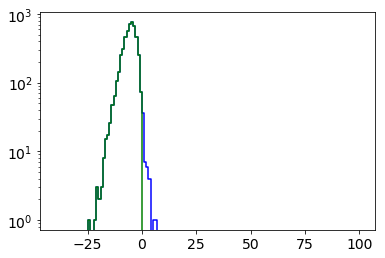

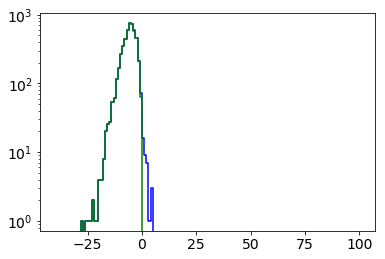

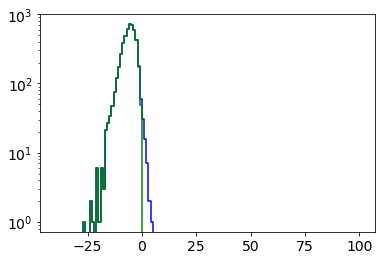

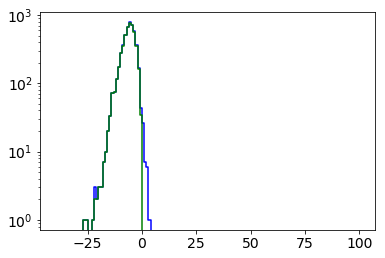

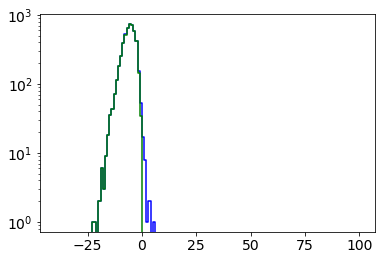

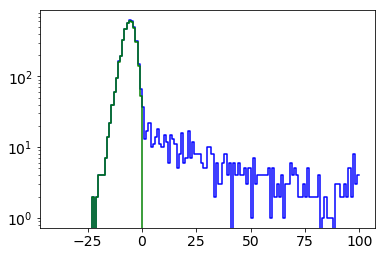

In [56]:
hnll_dict_vessel = {}
hnll_good_dict_vessel = {}

counter = 0
for key, df in dfdict_vessel.items():
    print('Running {}'.format(key))
    
    plt.figure(counter)
    
    hnll_dict_vessel[key] = hl.hist(df['best_fit_nll'],bins=np.linspace(-40.,100.,141))

    hnll_good_dict_vessel[key] = hl.hist(df['best_fit_nll'].loc[maskdict_vessel[key]],bins=np.linspace(-40.,100.,141))

    
    hl.plot1d(hnll_dict_vessel[key],color='b')
    hl.plot1d(hnll_good_dict_vessel[key],color='g')
    plt.title('dfdict_vessel {}'.format(key))
    
    #plt.xscale('log')
    #plt.xlim(-25.,5.)
    plt.yscale('log')
    
    counter += 1
    
            

Running 0.01x
Running 00.1x
Running 00.3x
Running 01.0x
Running 03.0x
Running 10.0x
Running 30.0x
Running 100.0x


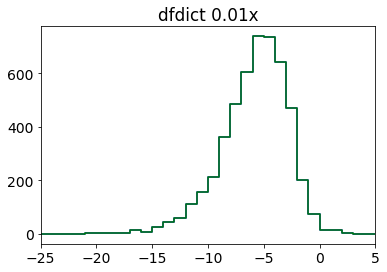

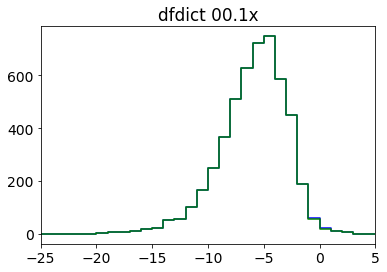

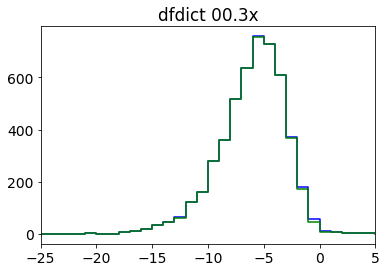

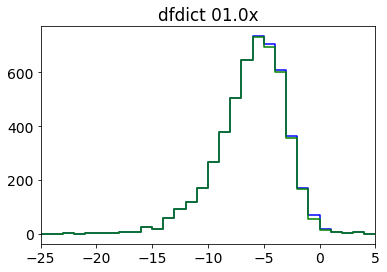

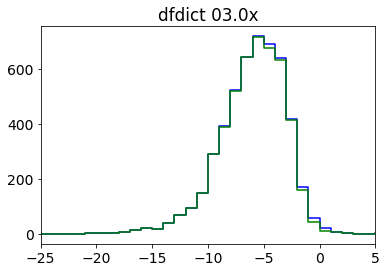

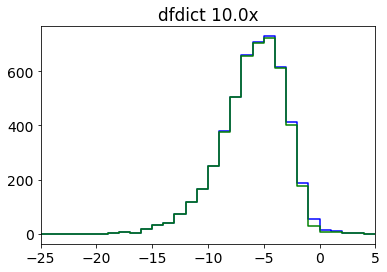

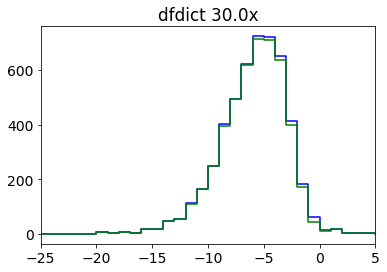

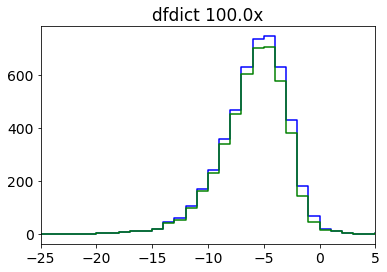

In [59]:
hnll_dict = {}
hnll_good_dict = {}

counter = 0
for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    plt.figure(counter)
    
    hnll_dict[key] = hl.hist(df['best_fit_nll'],bins=np.linspace(-40.,100.,141))

    hnll_good_dict[key] = hl.hist(df['best_fit_nll'].loc[maskdict[key]],bins=np.linspace(-40.,100.,141))

    
    hl.plot1d(hnll_dict[key],color='b')
    hl.plot1d(hnll_good_dict[key],color='g')
    plt.title('dfdict {}'.format(key))
    
    #plt.xscale('log')
    plt.xlim(-25.,5.)
    #plt.yscale('log')
    
    counter += 1
    

# Checking the distributions

In [67]:
optimized_binning_yaml = '../../config/Sensitivity2020_Optimized_DNN_Standoff_Binning_version1.yaml'
workspace2020_d024 = nEXOFitWorkspace.nEXOFitWorkspace(config=optimized_binning_yaml)
workspace2020_d024_ind = nEXOFitWorkspace.nEXOFitWorkspace(config=optimized_binning_yaml)


optimized_binning_components_table = '/p/vast1/nexo/sensitivity2020/pdfs/component_tables/ComponentsTable_D-024_merged-v10b_Optimized_DNN_Standoff_Binning_version1.h5'
workspace2020_d024.LoadComponentsTableFromFile(optimized_binning_components_table)
workspace2020_d024_ind.LoadComponentsTableFromFile(optimized_binning_components_table)




Loading input data froma previously-generated components table....

Loaded dataframe with 133 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	Material
	Radioassay ID
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']

Loading input data froma previously-generated components table....

Loaded dataframe with 133 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	Material
	Radioassay ID
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']
